In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import logging

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report, f1_score,precision_score, recall_score, roc_auc_score, roc_curve

In [2]:
df = pd.read_csv('/Users/mercedesquammie/Downloads/top20.csv', index_col = 0)

In [3]:
df = df.drop('spotify_artist_popularity_mean', axis = 1)

In [4]:
df.head()

,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,mean_segment_num_pitches,var_segment_num_pitches,mean_segment_num_pure_pitches,var_segment_num_pure_pitches,mean_segment_timbre,var_segment_timbre,num_tatums,mean_tatum_duration,var_tatum_duration,top_20
0,0.796196,-2.178146,0.030618,0.513133,-0.277509,0.778521,-0.806495,-0.236372,-0.153169,-0.839151,...,0.0,0.0,0.0,-4.440892e-16,2.273737e-13,0.0,0.0,-5.551115e-17,8.673617e-19,1
1,-1.466521,-0.508462,-0.921567,0.790982,-0.776142,0.778521,-0.712676,1.541868,-0.153169,2.511305,...,0.0,0.0,0.0,-4.440892e-16,2.273737e-13,0.0,0.0,-5.551115e-17,8.673617e-19,1
2,-1.373778,0.580463,-1.216437,-0.876113,-0.665248,0.778521,-0.823191,1.656466,-0.153169,-0.882363,...,0.0,0.0,0.0,-4.440892e-16,2.273737e-13,0.0,0.0,-5.551115e-17,8.673617e-19,1
3,-1.283932,0.111895,-1.517450,-1.431812,-2.446135,0.778521,-0.870895,1.403561,-0.153169,-0.799026,...,0.0,0.0,0.0,-4.440892e-16,2.273737e-13,0.0,0.0,-5.551115e-17,8.673617e-19,1
4,0.287341,0.191090,0.859939,-1.431812,1.260264,0.778521,-0.797749,-0.125726,-0.126556,-0.719547,...,0.0,0.0,0.0,-4.440892e-16,2.273737e-13,0.0,0.0,-5.551115e-17,8.673617e-19,1


In [5]:
df['top_20'].value_counts()

0    1115
1     308
Name: top_20, dtype: int64

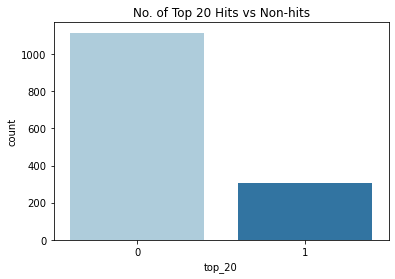

In [50]:
sns.countplot(x="top_20", data=df, palette='Paired')
plt.title('No. of Top 20 Hits vs Non-hits')
plt.savefig('top20plot.png')

## Balancing the Data

In [8]:
# Number of data points in the minority class
number_hits = len(df[df.top_20 == 1])
hits_indices = np.array(df[df.top_20 == 1].index)

# Picking the indices of the non-hit classes
non_hits_indices = df[df.top_20 == 0].index

# Out of the indices we picked, randomly select "x" number (number_hits)
random_nonhit_indices = np.random.choice(non_hits_indices, number_hits, replace = False)
random_nonhit_indices = np.array(random_nonhit_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([hits_indices,random_nonhit_indices])

# Under sample dataset
df2 = df.iloc[under_sample_indices,:]

X_undersample = df2.loc[:, df2.columns != 'top_20']
y_undersample = df2.loc[:, df2.columns == 'top_20']

In [10]:
# Showing ratio
print("non-hit songs: ", len(df2[df2.top_20 == 0]))
print("hit songs: ", len(df2[df2.top_20 == 1]))
print("Total number of songs in resampled data: ", len(df2))

non-hit songs:  308
hit songs:  308
Total number of songs in resampled data:  616


## Train Test Split

In [11]:
inputs = df2.drop('top_20', axis=1).copy()
target = df2['top_20']

In [12]:
X = inputs.values
y = target.values

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [14]:
print("Number songs X_train dataset: ", X_train.shape)
print("Number songs y_train dataset: ", y_train.shape)
print("Number songs X_test dataset: ", X_test.shape)
print("Number songs y_test dataset: ", y_test.shape)

Number songs X_train dataset:  (462, 111)
Number songs y_train dataset:  (462,)
Number songs X_test dataset:  (154, 111)
Number songs y_test dataset:  (154,)


## Logistic Regression

Before hyperparameter tuning

In [15]:
lr = LogisticRegression(max_iter = 1000, random_state = 42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.52      0.51      0.52        78
           1       0.51      0.51      0.51        76

    accuracy                           0.51       154
   macro avg       0.51      0.51      0.51       154
weighted avg       0.51      0.51      0.51       154



Hyper-Parameter Tuning with GridSearch CV

In [16]:
# parameter grid
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

In [17]:
clf = GridSearchCV(lr,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=5)                     # number of folds

In [18]:
clf.fit(X_train,y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
70 fits failed out of a total of 210.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 447, in _check_solver
    raise ValueError(
Val

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='accuracy')

In [19]:
print("Tuned Hyperparameters :", clf.best_params_)
print("Accuracy :",clf.best_score_)

Tuned Hyperparameters : {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Accuracy : 0.5714118747078073


In [20]:
lr1 = LogisticRegression(C = 1.0, 
                            penalty = 'l2', 
                            solver = 'newton-cg', max_iter = 1000, random_state = 42)

In [21]:
lr1.fit(X_train,y_train)
y_pred_lr1 = lr1.predict(X_test)
print(classification_report(y_test, y_pred_lr1))
confusion_matrix(y_test, y_pred_lr1)

              precision    recall  f1-score   support

           0       0.52      0.51      0.52        78
           1       0.51      0.51      0.51        76

    accuracy                           0.51       154
   macro avg       0.51      0.51      0.51       154
weighted avg       0.51      0.51      0.51       154



array([[40, 38],
       [37, 39]])

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

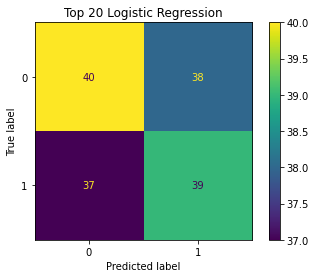

In [51]:
ConfusionMatrixDisplay.from_estimator(lr1, X_test, y_test)
plt.title('Top 20 Logistic Regression')
plt.savefig('lr20.png')
plt.show()

## SVM 

In [25]:
from sklearn import svm

In [26]:
rbf = svm.SVC(kernel='rbf', random_state = 42) #RBF Kernel

In [27]:
#Train the model using the training sets
rbf.fit(X_train, y_train)

SVC(random_state=42)

In [28]:
#Predict the response for test dataset
y_pred_rbf = rbf.predict(X_test)

In [29]:
print(classification_report(y_test, y_pred_rbf))

              precision    recall  f1-score   support

           0       0.53      0.51      0.52        78
           1       0.52      0.54      0.53        76

    accuracy                           0.53       154
   macro avg       0.53      0.53      0.53       154
weighted avg       0.53      0.53      0.53       154



In [30]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
 
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)
 
# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.505 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.505 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.505 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.505 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.505 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 4/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 5/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.500 total time=   0.1s
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.581 total time=   0.0s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.570 total time=   0.0s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.478 total time=   0.0s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.489 total time=   0.0s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.543 total time=   0.0s
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.538 total time=   0.0s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.602 total time=   0.0s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.522 total time=   0.0s
[CV 4/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.478 total time=   0.0s
[CV 5/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.533 total time=   0.1s
[CV 1/5] END ...C=1000, gamm

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [32]:
# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

#print Accuracy
print("Accuracy :",grid.best_score_)

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=100, gamma=0.001)
Accuracy : 0.571435250116877


In [33]:
grid_predictions = grid.predict(X_test)
 
# print classification report
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.54      0.54      0.54        78
           1       0.53      0.53      0.53        76

    accuracy                           0.53       154
   macro avg       0.53      0.53      0.53       154
weighted avg       0.53      0.53      0.53       154



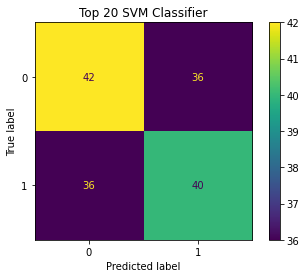

In [52]:
ConfusionMatrixDisplay.from_estimator(grid.best_estimator_, X_test, y_test)
plt.title('Top 20 SVM Classifier')
plt.savefig('SVM20.png')
plt.show()

## Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
# Instantiate and fit the RandomForestClassifier
forest = RandomForestClassifier(random_state = 42)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [37]:
# Make predictions for the test set
y_pred_forest = forest.predict(X_test)

In [38]:
# View the classification report for test data and predictions
print(classification_report(y_test, y_pred_forest))

              precision    recall  f1-score   support

           0       0.57      0.58      0.57        78
           1       0.56      0.55      0.56        76

    accuracy                           0.56       154
   macro avg       0.56      0.56      0.56       154
weighted avg       0.56      0.56      0.56       154



In [39]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [40]:
CV_rfc = GridSearchCV(estimator=forest, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [41]:
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 'auto',
 'n_estimators': 200}

In [43]:
print("Accuracy :",CV_rfc.best_score_)

Accuracy : 0.562739597942964


In [42]:
CV_rfc_pred = CV_rfc.predict(X_test)
 
# print classification report
print(classification_report(y_test, CV_rfc_pred))

              precision    recall  f1-score   support

           0       0.55      0.60      0.57        78
           1       0.54      0.49      0.51        76

    accuracy                           0.55       154
   macro avg       0.55      0.54      0.54       154
weighted avg       0.55      0.55      0.54       154



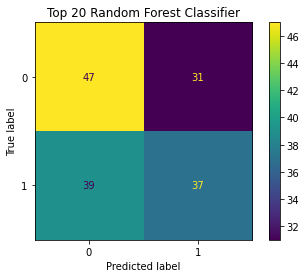

In [53]:
ConfusionMatrixDisplay.from_estimator(CV_rfc, X_test, y_test)
plt.title('Top 20 Random Forest Classifier')
plt.savefig('RFC20.png')
plt.show()